In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch

device = torch.device('cuda') if torch.cuda.is_available() \
                            else torch.device('cpu')


c:\Positive\env\VM\anaconda\envs\rlseven\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 代码用于离散环境的模型
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

In [3]:
# ----------------------------------------- #
# 参数设置
# ----------------------------------------- #

num_episodes = 500  # 总迭代次数
gamma = 0.98  # 折扣因子

actor_lr = 1e-3  # 策略网络的学习率
critic_lr = 1e-3  # 价值网络的学习率

n_hiddens = 16  # 隐含层神经元个数

env_name = 'CartPole-v1'

return_list = []  # 保存每个回合的return

In [4]:
# ----------------------------------------- #
# 环境加载
# ----------------------------------------- #

#env = gym.make(env_name, render_mode="human")
env = gym.make(env_name)

n_states = env.observation_space.shape[0]  # 状态数 4
n_actions = env.action_space.n  # 动作数 2

In [5]:
# ----------------------------------- #
# 构建策略网络--actor
# ----------------------------------- #

class PolicyNet(nn.Module):
    #
    def __init__(self, n_states, n_hiddens, n_actions):
        super(PolicyNet, self).__init__()

        #这里的n_states为4
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_actions)

    def forward(self, x):
        x = self.fc1(x)  # [b,n_states]-->[b,n_hiddens]
        x = F.relu(x)
        x = self.fc2(x)  # [b, n_actions]
        x = F.softmax(x, dim=1)  # [b, n_actions]  计算每个动作的概率
        #x = F.softmax(x, dim=1)：应用Softmax函数到上一步的输出上。
        #Softmax函数将输入的分数转换为概率分布，确保所有动作的概率之和为1。
        #dim=1指定了概率计算应沿着哪个维度进行，这里是对每个样本（batch中的每一行）分别计算概率。
        return x

n_states：整数，表示状态空间的大小，即每个状态向量的维度。
n_hiddens：整数，表示隐藏层的大小，即隐藏层神经元的数量。
n_actions：整数，表示动作空间的大小，即智能体可以执行的动作数量。

self.fc1：第一个全连接层（nn.Linear），它将输入状态从 n_states 维映射到 n_hiddens 维。这通常是网络的第一个隐藏层。
self.fc2：第二个全连接层，它将第一个隐藏层的输出从 n_hiddens 维映射到 n_actions 维。这通常是网络的输出层，用于生成动作概率分布。

网络结构：PolicyNet 包含两个顺序的全连接层，第一个层后接一个 ReLU 激活函数来引入非线性。第二个层的输出通过 softmax 函数转换为动作的概率分布。

全连接层（Fully Connected Layer，也称为 Dense Layer）是神经网络中的一种常见层类型，其特点是层中的每个输入神经元都与每个输出神经元相连。全连接层在处理一维数据时特别常见，例如在处理向量数据时。

以下是全连接层的一些关键特点：

1. **连接性**：全连接层中的每个输入节点都与每个输出节点通过权重相连。这意味着输入数据的每个特征都会影响输出的每个元素。

2. **权重矩阵**：全连接层可以表示为一个权重矩阵，其中权重矩阵的行数等于输出神经元的数量，列数等于输入神经元的数量。

3. **偏置项**：除了权重矩阵外，全连接层通常还包括一个偏置项向量，向量的每个元素对应一个输出神经元，用于调整输出值。

4. **线性组合**：输入数据通过权重矩阵进行线性组合，然后加上偏置项，得到全连接层的原始输出。

5. **激活函数**：全连接层的原始输出通常会通过一个激活函数（如 ReLU、Sigmoid 或 Tanh）来引入非线性，这有助于网络学习复杂的模式。

6. **特征转换**：全连接层可以将输入特征从一组空间映射到另一组空间，有助于提取和转换特征。

7. **在网络中的位置**：
   - 在前馈神经网络中，全连接层通常位于网络的中间或输出部分。
   - 在卷积神经网络（CNN）中，全连接层通常位于网络的末端，用于将卷积层和池化层提取的特征转换为最终的输出（如分类标签）。

8. **参数数量**：全连接层的参数数量相对较多，因为它需要为每个输入和输出神经元之间的连接分配权重。

9. **实现**：在深度学习框架中，如 PyTorch 或 TensorFlow，全连接层通常由 `nn.Linear` 或 `tf.keras.layers.Dense` 类实现。

例如，在 PyTorch 中，你可以这样创建一个全连接层：

```python
import torch.nn as nn

fc_layer = nn.Linear(in_features=64, out_features=128)
```

这行代码创建了一个输入大小为 64、输出大小为 128 的全连接层。这个层将接受一个形状为 `(*, 64)` 的输入张量（其中 `*` 表示任意数量的前缀维度，例如批次大小），并输出一个形状为 `(*, 128)` 的张量。

隐藏层（Hidden Layer）是神经网络中位于输入层和输出层之间的层，它们对输入数据进行变换和特征提取，但不直接与外部环境交互。以下是隐藏层的一些关键特点：

1. **中间处理**：隐藏层接收来自输入层的数据，通过变换生成更高级的特征表示，这些特征随后被传递到下一层或输出层。

2. **非线性变换**：隐藏层通常包含激活函数，如 ReLU、Sigmoid 或 Tanh，这些激活函数为网络引入非线性，使得网络能够学习和模拟复杂的数据模式。

3. **特征提取**：隐藏层负责从原始数据中提取特征。在多层网络中，较低层的隐藏层可能捕捉局部特征，而较高层可能捕捉更抽象的特征。

4. **网络深度**：隐藏层的数量和每层中的单元数决定了网络的深度。更深的网络通常具有更强的特征提取能力，但也可能导致计算复杂性和过拟合风险增加。

5. **参数学习**：隐藏层中的每个神经元都有一组权重和偏置，这些参数在训练过程中通过反向传播算法进行学习和更新。

6. **多层堆叠**：神经网络可以包含多个隐藏层，形成多层感知机（MLP）或其他类型的深度网络结构。

7. **网络复杂性**：隐藏层的添加增加了网络的复杂性，使其能够解决更复杂的问题，如图像识别、自然语言处理等。

8. **实现**：在深度学习框架中，隐藏层通常由全连接层（`nn.Linear` 在 PyTorch 中）或其他类型的层（如卷积层、循环层等）实现。

9. **训练中的作用**：在训练过程中，隐藏层的参数通过损失函数的梯度信息进行调整，以最小化预测误差。

10. **示例**：
    ```python
    import torch.nn as nn

    # 创建一个包含两个隐藏层的神经网络
    model = nn.Sequential(
        nn.Linear(10, 64),  # 第一个隐藏层，从10个输入特征到64个输出特征
        nn.ReLU(),         # 激活函数
        nn.Linear(64, 32),  # 第二个隐藏层，从64个输入特征到32个输出特征
        nn.ReLU(),         # 激活函数
        nn.Linear(32, 1)    # 输出层
    )
    ```
    在这个例子中，有两个隐藏层，每个隐藏层后面都跟着一个 ReLU 激活函数。

隐藏层是构建深度神经网络的基础，它们使得网络能够学习和表征数据中的复杂结构和模式。通过合理设计隐藏层的数量和大小，可以显著提高神经网络的性能和泛化能力。

激活函数（Activation Function）是神经网络中的一个重要组成部分，用于在网络的神经元（或称为单元）中引入非线性。如果没有激活函数，无论神经网络有多少层，整个网络都只能表示线性关系，这大大限制了它的表达能力。以下是激活函数的一些关键特点：

1. **非线性引入**：激活函数的主要作用是引入非线性，使得神经网络可以学习和模拟复杂的函数映射。

2. **数学函数**：激活函数通常是一个数学函数，它将输入值（或加权求和后的结果）映射到输出值。

3. **连续性和可微性**：大多数激活函数是连续且可微的，这对于使用梯度下降算法进行网络训练至关重要。

4. **饱和性**：某些激活函数（如 Sigmoid 或 Tanh）在输入值很大或很小的时候会饱和，这意味着它们在输入值极端时梯度接近零，可能导致梯度消失问题。

5. **选择多样性**：存在多种激活函数，如 Sigmoid、Tanh、ReLU（Rectified Linear Unit）、Leaky ReLU、PReLU、ELU（Exponential Linear Unit）等，每种都有其特点和适用场景。

6. **影响网络性能**：激活函数的选择可以影响神经网络的训练速度、收敛性和最终性能。

7. **在网络中的应用**：激活函数通常应用于全连接层或卷积层之后，作为每个神经元的输出。

8. **实现**：在深度学习框架中，激活函数通常作为层的一部分实现，例如在 PyTorch 中，`torch.nn.ReLU()`、`torch.nn.Sigmoid()` 等。

以下是一些常用的激活函数：

- **Sigmoid**：`σ(x) = 1 / (1 + e^(-x))`，输出范围在 (0, 1) 之间，常用于二分类问题。
- **Tanh**：`tanh(x) = (e^(x) - e^(-x)) / (e^(x) + e^(-x))`，输出范围在 (-1, 1) 之间。
- **ReLU**：`max(0, x)`，当输入大于0时输出输入值，否则输出0，有助于缓解梯度消失问题，但在输入非常小的情况下梯度为0。
- **Leaky ReLU**：`max(αx, x)`，其中 `α` 是一个小的正数，允许负输入有非零梯度。
- **PReLU**（Parametric ReLU）：`max(αx, x)`，`α` 是可学习的参数，为每个神经元提供适应性。
- **ELU**：`x` if `x > 0` else `α(e^x - 1)`，对于负值有一个非零输出，有助于缓解ReLU的死亡ReLU问题。

激活函数的选择取决于具体的应用和网络结构，有时需要通过实验来确定最适合的激活函数。

非线性引入是指在数学模型或系统中添加非线性特性，使得模型能够捕捉和表示数据中的复杂关系和模式。在机器学习和人工智能领域，特别是在构建神经网络时，非线性引入是非常关键的。

以下是非线性引入的几个关键点：

1. **数据复杂性**：现实世界的数据通常具有非线性特征，即数据之间的关系不是简单的直线或平面。非线性引入使模型能够学习和模拟这些复杂的数据结构。

2. **模型表达能力**：非线性函数可以提供比线性函数更丰富的表达能力。它们可以表示各种复杂的函数映射，包括曲线、折线、平面等。

3. **激活函数**：在神经网络中，非线性主要通过激活函数引入。激活函数是一类特殊的非线性函数，用于在神经元的输出中引入非线性变换。

4. **网络深度**：即使神经网络的层数很多，如果网络中没有非线性激活函数，整个网络的表达能力仍然有限，只能表示线性关系。非线性激活函数是实现深层网络的关键。

5. **解决线性不可分问题**：非线性引入使得神经网络能够解决线性不可分问题，即那些不能通过线性边界分开的数据点。

6. **泛化能力**：非线性模型通常具有更好的泛化能力，因为它们可以学习数据中的复杂模式，并在未见过的数据上做出预测。

7. **训练挑战**：虽然非线性引入提高了模型的表达能力，但也带来了训练上的挑战，如梯度消失或梯度爆炸问题，需要特殊的优化算法和技术来解决。

8. **函数逼近**：非线性激活函数使得神经网络能够逼近更复杂的函数，这是神经网络用于分类、回归和特征学习的基础。

9. **多样性**：存在多种非线性激活函数，每种函数都有其特点和适用场景，选择合适的激活函数对于构建有效的神经网络至关重要。

10. **实现**：在深度学习框架中，非线性激活函数通常作为层的一部分实现，可以轻松地添加到网络中。

非线性引入是神经网络能够学习和模拟复杂数据的关键因素之一，它为构建强大的人工智能系统提供了基础。

In [6]:
# ----------------------------------- #
# 构建价值网络--critic
# ----------------------------------- #

class ValueNet(nn.Module):

    def __init__(self, n_states, n_hiddens):

        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, 1)

    def forward(self, x):

        x = self.fc1(x)  # [b,n_states]-->[b,n_hiddens]
        x = F.relu(x)
        
        x = self.fc2(x)  # [b,n_hiddens]-->[b,1]  评价当前的状态价值state_value
        return x

In [7]:
# ----------------------------------- #
# 构建模型
# ----------------------------------- #

class PPO:
    def __init__(self, n_states, n_hiddens, n_actions, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        # 实例化策略网络
        self.actor = PolicyNet(n_states, n_hiddens, n_actions).to(device)
        # 实例化价值网络
        self.critic = ValueNet(n_states, n_hiddens).to(device)
        # 策略网络的优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        # 价值网络的优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)

        self.gamma = gamma  # 折扣因子
        self.lmbda = lmbda  # GAE优势函数的缩放系数
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    # 动作选择
    def take_action(self, state):

        # 将标量值放入列表中，然后转换为数组
        #state = np.array([state])

        # 确保 state 是一个具有 n_states 个特征的数组
        #state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        
        # 维度变换 [n_state]-->tensor[1,n_states]
        state = torch.tensor(state[np.newaxis, :]).to(self.device)
        # 当前状态下，每个动作的概率分布 [1,n_states]
        probs = self.actor(state)
        #比如[0.5, 0.5]
        # 创建以probs为标准的概率分布
        action_list = torch.distributions.Categorical(probs)
        # 依据其概率随机挑选一个动作
        action = action_list.sample().item()
        
        return action

    # 训练
    def learn(self, transition_dict):
        # 提取数据集
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).to(self.device).view(-1,1)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).to(self.device).view(-1,1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).to(self.device).view(-1,1)

        # 目标，下一个状态的state_value  [b,1]
        next_q_target = self.critic(next_states)
        # 目标，当前状态的state_value  [b,1]
        td_target = rewards + self.gamma * next_q_target * (1-dones)
        # 预测，当前状态的state_value  [b,1]
        td_value = self.critic(states)
        # 目标值和预测值state_value之差  [b,1]
        td_delta = td_target - td_value

        # 时序差分值 tensor-->numpy  [b,1]
        td_delta = td_delta.cpu().detach().numpy()
        advantage = 0  # 优势函数初始化
        advantage_list = []

        # 计算优势函数
        for delta in td_delta[::-1]:  # 逆序时序差分值 axis=1轴上倒着取 [], [], []
            # 优势函数GAE的公式
            advantage = self.gamma * self.lmbda * advantage + delta
            
            advantage_list.append(advantage)
        # 正序
        advantage_list.reverse()
        # numpy --> tensor [b,1]
        advantage = torch.tensor(advantage_list, dtype=torch.float).to(self.device)

        # 策略网络给出每个动作的概率，根据action得到当前时刻下该动作的概率
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        # 一组数据训练 epochs 轮
        for _ in range(self.epochs):
            # 每一轮更新一次策略网络预测的状态
            log_probs = torch.log(self.actor(states).gather(1, actions))
            # 新旧策略之间的比例
            ratio = torch.exp(log_probs - old_log_probs)
            # 近端策略优化裁剪目标函数公式的左侧项
            surr1 = ratio * advantage
            # 公式的右侧项，ratio小于1-eps就输出1-eps，大于1+eps就输出1+eps
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps) * advantage

            # 策略网络的损失函数
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            # 价值网络的损失函数，当前时刻的state_value - 下一时刻的state_value
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

            # 梯度清0
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            # 反向传播
            actor_loss.backward()
            critic_loss.backward()
            # 梯度更新
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [8]:
# ----------------------------------------- #
# 模型构建
# ----------------------------------------- #

agent = PPO(n_states=n_states,  # 状态数
            n_hiddens=n_hiddens,  # 隐含层数
            n_actions=n_actions,  # 动作数
            actor_lr=actor_lr,  # 策略网络学习率
            critic_lr=critic_lr,  # 价值网络学习率
            lmbda = 0.95,  # 优势函数的缩放因子
            epochs = 10,  # 一组序列训练的轮次
            eps = 0.2,  # PPO中截断范围的参数
            gamma=gamma,  # 折扣因子
            device = device
            )

CartPole-v1 返回 done = True 的情况：

在CartPole-v1环境中，done = True 会在以下情况之一发生时返回：
杆子（pole）与垂直方向的夹角超过一定限制（例如，15度）。
小车（cart）的位置超出轨道的一定范围（例如，左右偏离中心超过2.4个单位）。
达到了环境预设的最大步数限制。

In [9]:
# ----------------------------------------- #
# 训练--回合更新 on_policy
# ----------------------------------------- #

for i in range(num_episodes):
    
    state = env.reset()  # 环境重置
    # 这行代码的作用是重置环境并获取初始状态。`env.reset()` 方法用于重置环境到初始状态，并返回初始观察(observation)。
    # 由于 `env.reset()` 返回的是一个数组，`[0]` 用于从这个数组中获取第一个元素，即初始状态。
    # 这通常用于强化学习环境中，以开始一个新的回合。

    done = False  # 任务完成的标记

    episode_return = 0  # 累计每回合的reward

    # 构造数据集，保存每个回合的状态数据
    transition_dict = {
        'states': [],
        'actions': [],
        'next_states': [],
        'rewards': [],
        'dones': [],
    }

    while not done:

        action = agent.take_action(state)  # 动作选择

        next_state, reward, done, _  = env.step(action)  # 环境更新

        print(done)
        # 保存每个时刻的状态\动作\...
        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['next_states'].append(next_state)
        transition_dict['rewards'].append(reward)
        transition_dict['dones'].append(done)
        # 更新状态
        state = next_state
        # 累计回合奖励
        episode_return += reward

    # 保存每个回合的return
    return_list.append(episode_return)
    # 模型训练
    agent.learn(transition_dict)

    # 打印回合信息
    print(f'iter:{i}, return:{np.mean(return_list[-10:])}')

False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:0, return:14.0
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:1, return:22.5
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:2, return:22.0
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:3, return:20.0
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:4, return:21.8
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:5, return:20.833333333333332
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

c:\Positive\env\VM\anaconda\envs\rlseven\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)


iter:18, return:27.1
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:19, return:29.4
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:20, return:29.7
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:21, return:31.3
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
iter:22, return:31.8
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

这行代码是 Python 中的一个打印语句，使用了格式化字符串（f-string）来输出信息。这里是对代码的详细解释：

- `print`：这是 Python 的打印函数，用于将信息输出到控制台。

- `f'...'`：这是一个 f-string，即格式化字符串，允许你在字符串内部直接嵌入表达式的值。

- `{i}`：这是一个占位符，`i` 是一个变量，它将被替换为变量 `i` 的当前值，通常表示迭代次数的索引或计数。

- `np.mean(return_list[-10:])`：这是一个调用 NumPy 库的 `mean` 函数来计算列表 `return_list` 最后10个元素的平均值的表达式。`return_list` 应该是一个存储了多次迭代回报值的列表。`[-10:]` 是一个切片操作，它取得列表中从倒数第10个元素到列表末尾的元素。

- `return_list`：这是一个列表，其中存储了智能体在多次迭代中的回报值。

- `np`：这是 NumPy 库的常用别名，NumPy 是一个广泛使用的 Python 科学计算库。

整行代码的作用是打印出当前迭代次数（`i`）和最近10次迭代的平均回报值。这通常用于监控强化学习训练过程中智能体性能的变化趋势。

例如，如果 `return_list` 是 `[220, 240, 210, 230, 250, 260, 270, 290, 300, 310]` 并且 `i` 是 10，那么这条打印语句将会输出：

```
iter:10, return:270.0
```

这表明在第10次迭代时，最近10次迭代的平均回报是 270.0。这是一个有用的指标，因为它可以给出智能体最近的性能表现，而不是单次迭代的回报，后者可能会有很大的随机性。

In [10]:
print(return_list)

[14.0, 31.0, 21.0, 14.0, 29.0, 16.0, 23.0, 11.0, 21.0, 13.0, 14.0, 25.0, 19.0, 54.0, 10.0, 39.0, 22.0, 38.0, 37.0, 36.0, 17.0, 41.0, 24.0, 57.0, 33.0, 63.0, 31.0, 41.0, 19.0, 26.0, 52.0, 89.0, 71.0, 62.0, 48.0, 120.0, 92.0, 97.0, 34.0, 26.0, 58.0, 145.0, 62.0, 123.0, 127.0, 38.0, 153.0, 117.0, 167.0, 252.0, 160.0, 76.0, 36.0, 33.0, 140.0, 142.0, 229.0, 325.0, 500.0, 230.0, 142.0, 191.0, 500.0, 64.0, 255.0, 216.0, 263.0, 176.0, 305.0, 264.0, 306.0, 316.0, 416.0, 500.0, 296.0, 500.0, 500.0, 500.0, 441.0, 290.0, 438.0, 170.0, 215.0, 116.0, 311.0, 342.0, 500.0, 500.0, 500.0, 214.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 494.0, 500.0, 500.0, 500.0, 209.0, 500.0, 500.0, 500.0, 349.0, 406.0, 377.0, 449.0, 500.0, 421.0, 397.0, 205.0, 237.0, 273.0, 162.0, 187.0, 273.0, 355.0, 171.0, 500.0, 500.0, 315.0, 471.0, 398.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 368.0, 500.0, 362.0, 500.0, 500.0, 259.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 300.0, 500.0, 500.0, 50

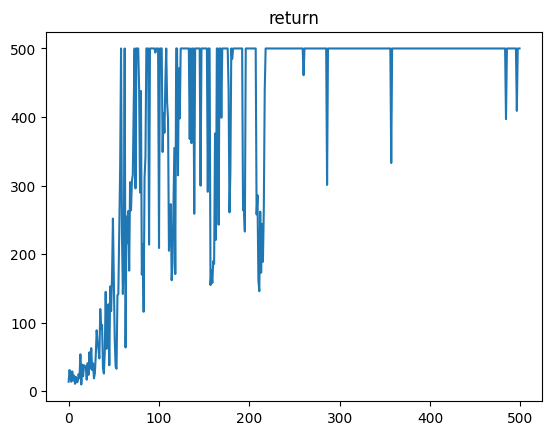

In [11]:
# -------------------------------------- #
# 绘图
# -------------------------------------- #

plt.plot(return_list)
plt.title('return')
plt.show()

In [12]:
#%pip install scipy

In [13]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.interpolate import make_interp_spline

# # 假设 return_list 是原始数据
# x = np.arange(len(return_list))  # 原始x轴点集合
# y = np.array(return_list)  # 原始y轴数据

# # 生成新的、更密集的x轴点集合
# x_new = np.linspace(x.min(), x.max(), 300) 

# # 创建插值函数
# spl = make_interp_spline(x, y, k=3)  # k是平滑曲线的强度

# # 使用插值函数和新的x轴点集合生成平滑的y轴数据
# y_smooth = spl(x_new)

# # 绘制平滑曲线
# plt.plot(x_new, y_smooth)
# plt.title('return')
# plt.show()